In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Imports

In [49]:
# file imports
file_path_forecasts = '../data/raw/ibes-forecasts.parquet'

# IBES forecasts
df_forecasts = pd.read_parquet(file_path_forecasts)

In [50]:
df_forecasts.head()

,TICKER,CUSIP,OFTIC,CNAME,ESTIMATOR,ANALYS,FPI,MEASURE,VALUE,FPEDATS,REVDATS,ANNDATS,ACTUAL,ANNDATS_ACT
0,0000,87482X10,TLMR,TALMER BANCORP,149,119962,1,EPS,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30
1,0000,87482X10,TLMR,TALMER BANCORP,228,80474,1,EPS,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
2,0000,87482X10,TLMR,TALMER BANCORP,952,50789,1,EPS,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
3,0000,87482X10,TLMR,TALMER BANCORP,873,79092,1,EPS,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
4,0000,87482X10,TLMR,TALMER BANCORP,1267,71182,1,EPS,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30


In [51]:
df_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620437 entries, 0 to 2620436
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   TICKER       object 
 1   CUSIP        object 
 2   OFTIC        object 
 3   CNAME        object 
 4   ESTIMATOR    int64  
 5   ANALYS       int64  
 6   FPI          int64  
 7   MEASURE      object 
 8   VALUE        float64
 9   FPEDATS      object 
 10  REVDATS      object 
 11  ANNDATS      object 
 12  ACTUAL       float64
 13  ANNDATS_ACT  object 
dtypes: float64(2), int64(3), object(9)
memory usage: 279.9+ MB


# Preprocessing
df_forecasts:
- Lower case all columns in df_forecasts
- Drop unncessary columns
- Include only forecasts issued no earlier than 1 year ahead and no later than 30 days before fiscal year end
- Rename columns
- Delete rows with actual_eps = NAN or estimated_eps = NAN
- Exclude forecasts for companies which only one analyst provides a forecast
- Exclude all analysts appearing in the initial 2-3 years of the dataset (migitating problem of experience)
- (Retain the last forecast an analyst issues in a particular year)
- ...

In [52]:
# lower case
df_forecasts = df_forecasts.rename(columns={col: col.lower() for col in df_forecasts.columns})

# Drop unncessary columns
columns_to_drop = ["fpi","measure","cusip"]
df_forecasts = df_forecasts.drop(columns=columns_to_drop)

In [53]:
# convert columns with dates to datetime
def convert_to_datetime(df):
    columns_to_convert = ['fpedats','revdats', "anndats", 'anndats_act']
    for column in columns_to_convert:
        df[column] = pd.to_datetime(df[column])
    return df
df_forecasts = convert_to_datetime(df_forecasts)

# filter forecasts  based on time
df_forecasts['forecast_horizon'] = df_forecasts['fpedats'] - df_forecasts['anndats']
df_forecasts = df_forecasts[(df_forecasts['forecast_horizon']> pd.Timedelta(days=30))&(df_forecasts['forecast_horizon']<pd.Timedelta(days=365))]

# calculate the mean forecast horizon of analyst i's forecasts for company j in fiscal period t and append to df
df_forecasts['mean_forecast_horizon_days'] = df_forecasts.groupby(['analys','ticker','fpedats'])['forecast_horizon'].transform('mean')
df_forecasts['mean_forecast_horizon_days'] = df_forecasts['mean_forecast_horizon_days'].dt.days
df_forecasts.head()

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,forecast_horizon,mean_forecast_horizon_days
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182


In [54]:
# test
analyst_id = 113333
subset_analyst_i = df_forecasts[(df_forecasts['ticker'] == "AAPL") & (df_forecasts['fpedats'].dt.year == 2020) & (df_forecasts['analys'] == analyst_id)]
subset_analyst_i

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,forecast_horizon,mean_forecast_horizon_days
128641,AAPL,AAPL,APPLE,171,113333,3.2565,2020-09-30,2020-01-22,2019-10-30,3.28,2020-10-29,336 days,291
128696,AAPL,AAPL,APPLE,171,113333,3.3510,2020-09-30,2020-01-28,2020-01-28,3.28,2020-10-29,246 days,291


rename columns to natural language

In [55]:
# rename columns
df_forecasts = df_forecasts.rename(columns={"ticker": "ibes_ticker_pk", "oftic": "official_ticker", "cname": "company_name",
                                            "analys": "analyst", "value": "estimated_eps", "fpedats": "fiscal_period_ending", 
                                            "revdats": "revision_date", "anndats": "announce_date", "actual": "actual_eps", "anndats_act": "announce_date_actual",
                                            "difference_date": "forecast_horizon"})

In [56]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182


remove empty rows and cut off time horizon

In [57]:
# drop all rows where the actual_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['actual_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['actual_eps'])

Number of rows dropped:  180990


In [58]:
# drop all rows where the estimated_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['estimated_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['estimated_eps'])

Number of rows dropped:  145


In [ ]:
# plot the forecast count by year over time for the entire dataset
df_forecasts['fiscal_year'] = df_forecasts['fiscal_period_ending'].dt.year
df_forecasts['actual_announce_year'] = df_forecasts['announce_date'].dt.year

In [61]:
# remove all rows of where actual_announce_year = 2023 and print the number of rows dropped
print("Number of rows dropped: ", df_forecasts['actual_announce_year'].value_counts().loc[2023])
df_forecasts = df_forecasts[df_forecasts['actual_announce_year'] != 2023]


Number of rows dropped:  5003


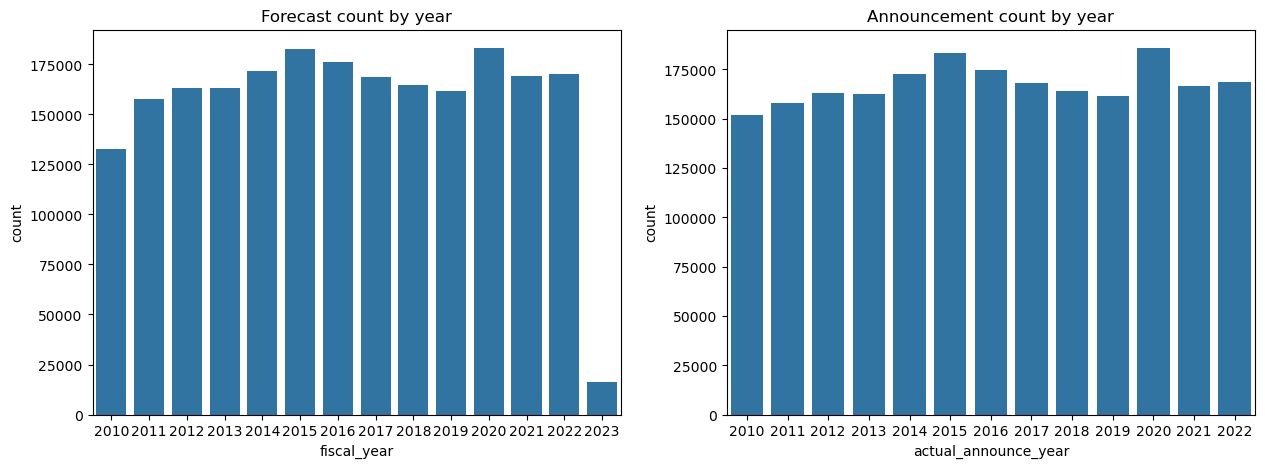

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=df_forecasts, x='fiscal_year', ax=ax[0])
ax[0].set_title('Forecast count by year')
sns.countplot(data=df_forecasts, x='actual_announce_year', ax=ax[1])
ax[1].set_title('Announcement count by year')
plt.show()

# Accuracies

## Variant 1: PMAFE 
PMAFE is the proportional mean absolute forecast error

$$PMAFE = \frac{DAFE_{ijt}}{\overline{AFE_{jt}}} = \frac{AFE_{ijt} - \overline{AFE_{jt}}}{\overline{AFE_{jt}}} $$

where 
- $AFE_{ijt}$ is the absolute forecast error for analyst i's forecast of firm j for year t, and 
- $\overline{AFE_{jt}}$ is the mean absolute forecast error for firm j for year t

Negative PMAFE: better than average performance of analyst i (capped at -1.0)

Postive PMAFE: worse than average performance (theoretically towards infinity)

Source: Analyst forecast accuracy:
Do ability, resources, and
portfolio complexity matter?q
Michael B. Clement

In [15]:
def calculate_pmafe(df):
    """
    This function first calculates the absolute forecast error for each analyst i forecast of firm j in year t
    If analyst i has multiple forecasts for firm j in year t, the function calculates the average forecast error
    In the second step an extra column is calculated for the overall forecast error is calculate for each firm j in year t
    In the third step, the function calculates the PMAFE for each analyst i forecast of firm j in year t
    This function adds new columns to the dataframe:
    - afe_analyst_i: the absolute forecast error for each analyst i forecast of firm j in year t
    - afe_analyst_ijt_mean: the average absolute forecast error for each analyst i forecast of firm j in year t
    - afe_firm_jt_mean: the overall forecast error for each firm j in year t
    - pmafe: the PMAFE for each analyst i forecast of firm j in year t
    """
    # Step 1: Calculate the average absolute forecast error for each analyst i forecast of firm j in year t
    df['afe_analyst_i'] = np.abs(df['estimated_eps'] - df['actual_eps'])
    
    df_grouped = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending']).agg({'afe_analyst_i': 'mean'}).reset_index()
    df_grouped = df_grouped.rename(columns={'afe_analyst_i': 'afe_analyst_ijt_mean'})
    df = pd.merge(df, df_grouped, on=['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'], how='left')
    
    # Step 2: Calculate the overall forecast error for each firm j in year t
    df['afe_firm_jt_mean'] = df.groupby(["ibes_ticker_pk", "fiscal_period_ending"])["afe_analyst_i"].transform("mean")
    
    # Step 3: Calculate the PMAFE for each analyst i forecast of firm j in year t
    df['pmafe'] = (df['afe_analyst_ijt_mean'] - df['afe_firm_jt_mean']) / df['afe_firm_jt_mean']
    
    return df

In [16]:
df_forecasts = calculate_pmafe(df_forecasts)
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200,2014,2014,0.48,0.376000,0.3575,0.051748
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214,2014,2014,0.38,0.367143,0.3575,0.026973
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182,2014,2014,0.55,0.404000,0.3575,0.130070
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187,2014,2014,0.41,0.424286,0.3575,0.186813
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182,2014,2014,0.35,0.142500,0.3575,-0.601399


### Descriptive Analysis PMAFE

In [17]:
# show me all rows where pmafe is NaN and print the count
print("Number of rows with pmafe NaN: ", df_forecasts['pmafe'].isna().sum())

Number of rows with pmafe NaN:  102


Exclude forecasts for companies in year t, if only one analyst provides a forecast (otherwise pmafe = NaN if actual == estimated) AND the analyst provides a perfect forecast

In [18]:
# Exclude forecasts for companies in year t for which only one analyst provides a forecast (otherwise pmafe = NaN if actual == estimated)
print(df_forecasts.shape[0])

df_forecasts['analyst_count'] = df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

df_forecasts = df_forecasts[(df_forecasts['analyst_count'] > 1) & (df_forecasts["afe_analyst_i"] != 0)]

print(df_forecasts.shape[0])


2185798
2137411


In [19]:
# Whats the lowest and highest PMAFE?
print("The lowest PMAFE is: ", df_forecasts['pmafe'].min())
print("The highest PMAFE is: ", df_forecasts['pmafe'].max())

The lowest PMAFE is:  -0.9999847530470667
The highest PMAFE is:  67.00421113621117


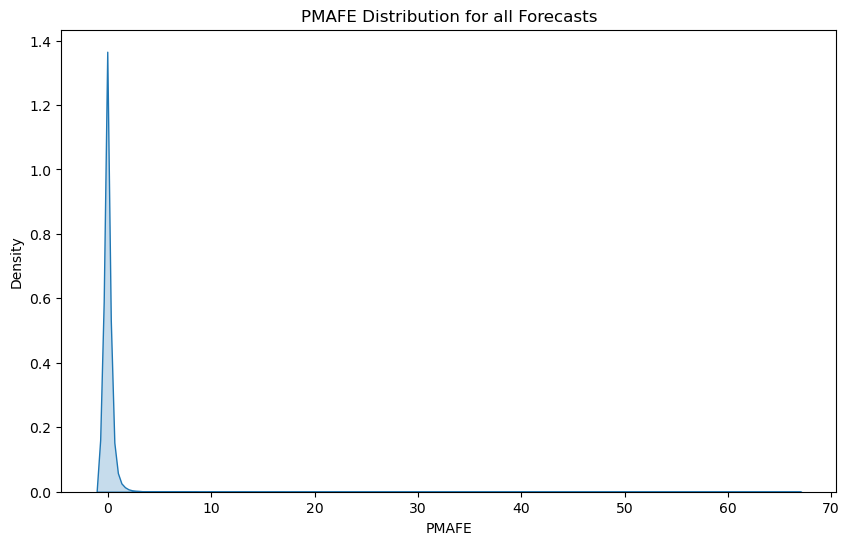

In [20]:
# density plot of PMAFE for all forecasts
plt.figure(figsize=(10, 6))
sns.kdeplot(df_forecasts['pmafe'], fill=True)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Density")
plt.show()

# Feature Engineering
## From RAW df

### Feature: Broker Size

## From collapsed df

### Collapse df

in the final df, one row should correspond to one analyst i's mean forecast of firm j in fiscal year t with accuracy measure pmafe

columns:
 - ibes_ticker_pk
 - company_name
 - gvkey
 - fiscal_period_ending
 - analyst
 - estimator
 - estimated_eps
 - mean_forecast_horizon
 - actual_eps
 - announce_date_actual
 - pmafe
 - afe_analyst_i_mean
 - afe_firm_j_mean
 - feature x
 - ...

### Feature : Coverage

In [23]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200,2014,2014,0.48,0.376000,0.3575,0.051748,28
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214,2014,2014,0.38,0.367143,0.3575,0.026973,28
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182,2014,2014,0.55,0.404000,0.3575,0.130070,28
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187,2014,2014,0.41,0.424286,0.3575,0.186813,28
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182,2014,2014,0.35,0.142500,0.3575,-0.601399,28


In [24]:
# test
analyst_id = 113333
test = df_forecasts[(df_forecasts['official_ticker'] == "AAPL") & (df_forecasts['fiscal_period_ending'].dt.year == 2018) & (df_forecasts['analyst'] == analyst_id)]
test

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
99534,AAPL,AAPL,APPLE,171,113333,2.900,2018-09-30,2018-01-29,2017-11-02,2.9775,2018-11-01,332 days,196,2018,2017,0.0775,0.06,0.130797,-0.541273,208
99597,AAPL,AAPL,APPLE,171,113333,2.935,2018-09-30,2018-04-30,2018-02-01,2.9775,2018-11-01,241 days,196,2018,2018,0.0425,0.06,0.130797,-0.541273,208
99664,AAPL,AAPL,APPLE,171,113333,2.885,2018-09-30,2018-07-30,2018-05-01,2.9775,2018-11-01,152 days,196,2018,2018,0.0925,0.06,0.130797,-0.541273,208
99706,AAPL,AAPL,APPLE,171,113333,2.950,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,2018,2018,0.0275,0.06,0.130797,-0.541273,208


In [25]:
# Group by 'ibes_ticker_pk', 'analyst', 'fiscal_period_ending' and find the row with the minimum 'forecast_horizon'
min_forecast = test.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'])['forecast_horizon'].idxmin()

# Extract rows with the minimum forecast horizon
min_forecast_df = test.loc[min_forecast]

In [26]:
min_forecast_df

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
99706,AAPL,AAPL,APPLE,171,113333,2.95,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,2018,2018,0.0275,0.06,0.130797,-0.541273,208


In [27]:
def collapse_processed_df(df):
    """_summary_
    This function collapses/groups the input df into the final df so that one row should correspond to one analyst 
    i's forecast of firm j in fiscal year t with accuracy measure pmafe and other relevant features
    """
    min_forecast = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'])['forecast_horizon'].idxmin()
    min_forecast_df = df.loc[min_forecast]
    return min_forecast_df


In [28]:
collapsed_df = collapse_processed_df(df_forecasts)

In [29]:
# all unique tickets analyst 1133333 has forecasted in 2018
analyst_113333 = collapsed_df[collapsed_df['analyst'] == 113333]
analyst_113333['ibes_ticker_pk'].unique()

array(['AAPL', 'AMCV', 'AMER', 'BBUY', 'CDLX', 'CDPD', 'CMCS', 'CRTO',
       'CSTR', 'DCHA', 'DCHA/2', 'DELL', 'DISH', 'DLIB', 'DMRC', 'DTSY',
       'FBK', 'GM12', 'GOOG', 'GOOG/1', 'GRUB', 'LCAP', 'LOGI', 'LYFT',
       'MVSN', 'NFLX', 'NWS', 'PPPP', 'RDFN', 'RNWK', 'SNE', 'SNIW',
       'TIVO', 'TWCA', 'TWEE', 'UEIC', 'VIA', 'VIAB', 'YELP', 'ZIL',
       'ZIL/1'], dtype=object)

In [30]:
filtered_df = collapsed_df[(collapsed_df['analyst'] == analyst_id) & (collapsed_df['fiscal_period_ending'].dt.year == 2018) & ((collapsed_df['official_ticker'] == "NFLX") | (collapsed_df['official_ticker'] == "AAPL"))]
filtered_df

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
99706,AAPL,AAPL,APPLE,171,113333,2.95,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,2018,2018,0.0275,0.060,0.130797,-0.541273,208
1377252,NFLX,NFLX,NETFLIX INC.,171,113333,2.62,2018-12-31,2019-01-15,2018-10-16,2.6800,2019-01-17,76 days,211,2018,2018,0.0600,0.285,0.150541,0.893166,205


# Export df

In [31]:
import os 
new_folder_path = '../data/processed' 

if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
file_path = os.path.join(new_folder_path, 'forecasts_pmafe_v2.csv')
collapsed_df.to_csv(file_path)